***Note: this is the modulatedCooperative.ipynb notebook. The
PDF version "Modulated Cooperative Enzyme-catalysed Reactions"
is available [here](modulatedCooperative.pdf).***

# Introduction
*"the ordinary laws [Michaelis-Menten] are inadequate for supplying the degree of control needed for metabolism"*  <cite data-cite="Cor12">(Cornish-Bowden, 2012)</cite>. In fact, key metabolic enzymes display *cooperativity* which *"display the property of responding with exceptional sensitivity to changes in metabolite concentrations"*
<cite data-cite="Cor12">(Cornish-Bowden, 2012)</cite>.

Cooperativity is discussed in the notebook [Cooperativity](Cooperativity.ipynb). Here, the cooperativity is augmented by *competitive activation and inhibition* to provide a mechanism for modulation and hence feedback control.

This note gives a bond graph <cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite> interpretation of such modulated cooperativity and uses the iterative properties of [BondGraphTools](https://pypi.org/project/BondGraphTools/) <cite data-cite="CudGawPanCra19X">(Cudmore et. al., 2019)</cite> to build high-order modulated cooperative systems.


## Import some python code
The bond graph analysis uses a number of Python modules:

In [1]:
## Some useful imports

import BondGraphTools as bgt
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import IPython.display as disp

## Stoichiometric analysis
import stoich as st

## SVG bg representation conversion
import svgBondGraph as sbg

## Modular bond graphs
import modularBondGraph as mbg

## Data structure copy
import copy

## Set quiet=False for verbose output
quiet = True

# Modulated Cooperative Enzyme-catalysed Reaction

<cite data-cite="KeeSne09">(Keener and Sneyd, 2009)</cite>, Section 1.4.4, discusses cooperativity. This section gives a bond graph interpretation. This is done in two ways:

1. As a graphical representation of a two-stage cooperative enzyme-catalysed reaction.
2. As a generic representation of an N-stage cooperative enzyme-catalysed reaction using  [bond-graph tools](https://pypi.org/project/BondGraphTools/)

## Enzyme-catalysed reaction
The basic enzyme-catalysed reaction is given in this section. It is the basic building block of cooperative enzyme-catalysed reactions
More details are given by <cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite>.


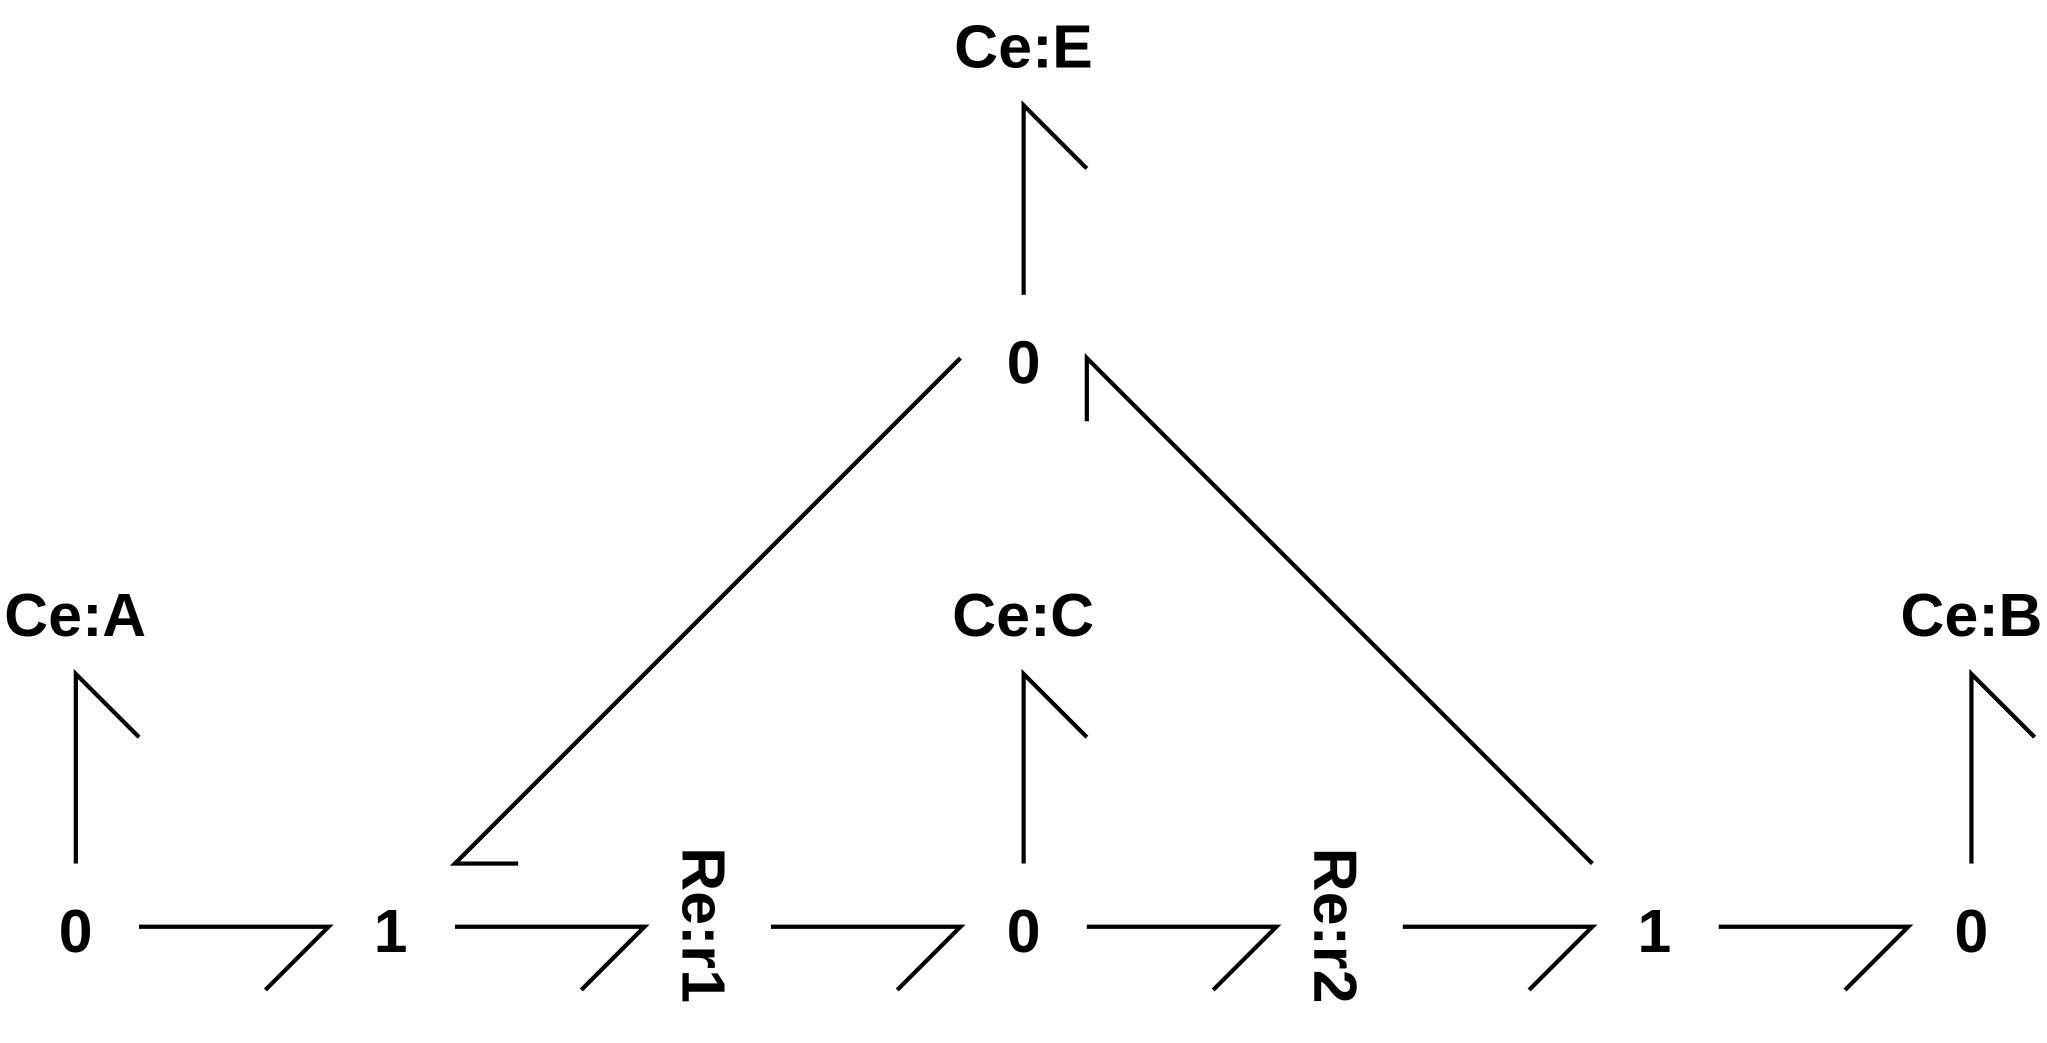

In [2]:
## Enzyme-catalysed reaction
sbg.model('RE_abg.svg')
import RE_abg
disp.SVG('RE_abg.svg')

In [3]:
s = st.stoich(RE_abg.model(),quiet=quiet)
disp.Latex(st.sprintrl(s,chemformula=True))

<IPython.core.display.Latex object>

## Modulation
Competitive inhibition and activation are discussed in chapter 6 of <cite data-cite="Cor12">(Cornish-Bowden, 2012)</cite>.

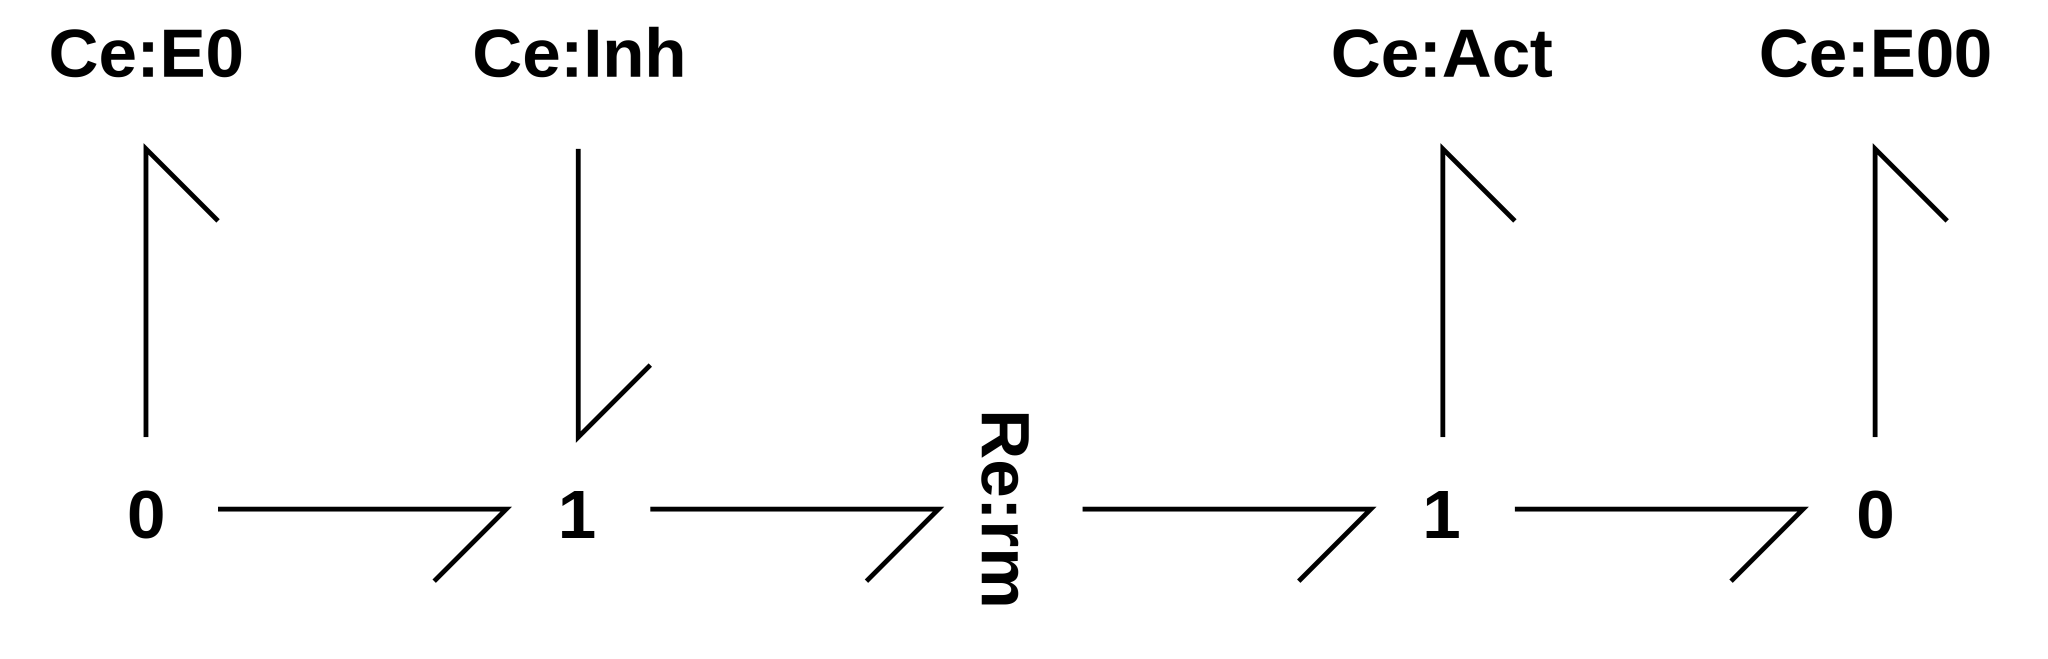

In [4]:
## Modulation
sbg.model('Mod_abg.svg')
import Mod_abg
disp.SVG('Mod_abg.svg')

In [5]:
s = st.stoich(Mod_abg.model(),quiet=quiet)
disp.Latex(st.sprintrl(s,chemformula=True))

<IPython.core.display.Latex object>

## Two-stage cooperative enzyme-catalysed reaction (N=2) with modulation<a id='coop2'></a>
The cooperative enzyme-catalysed reaction is modulated by the activation species (Act) and the inhibition species (Inh).

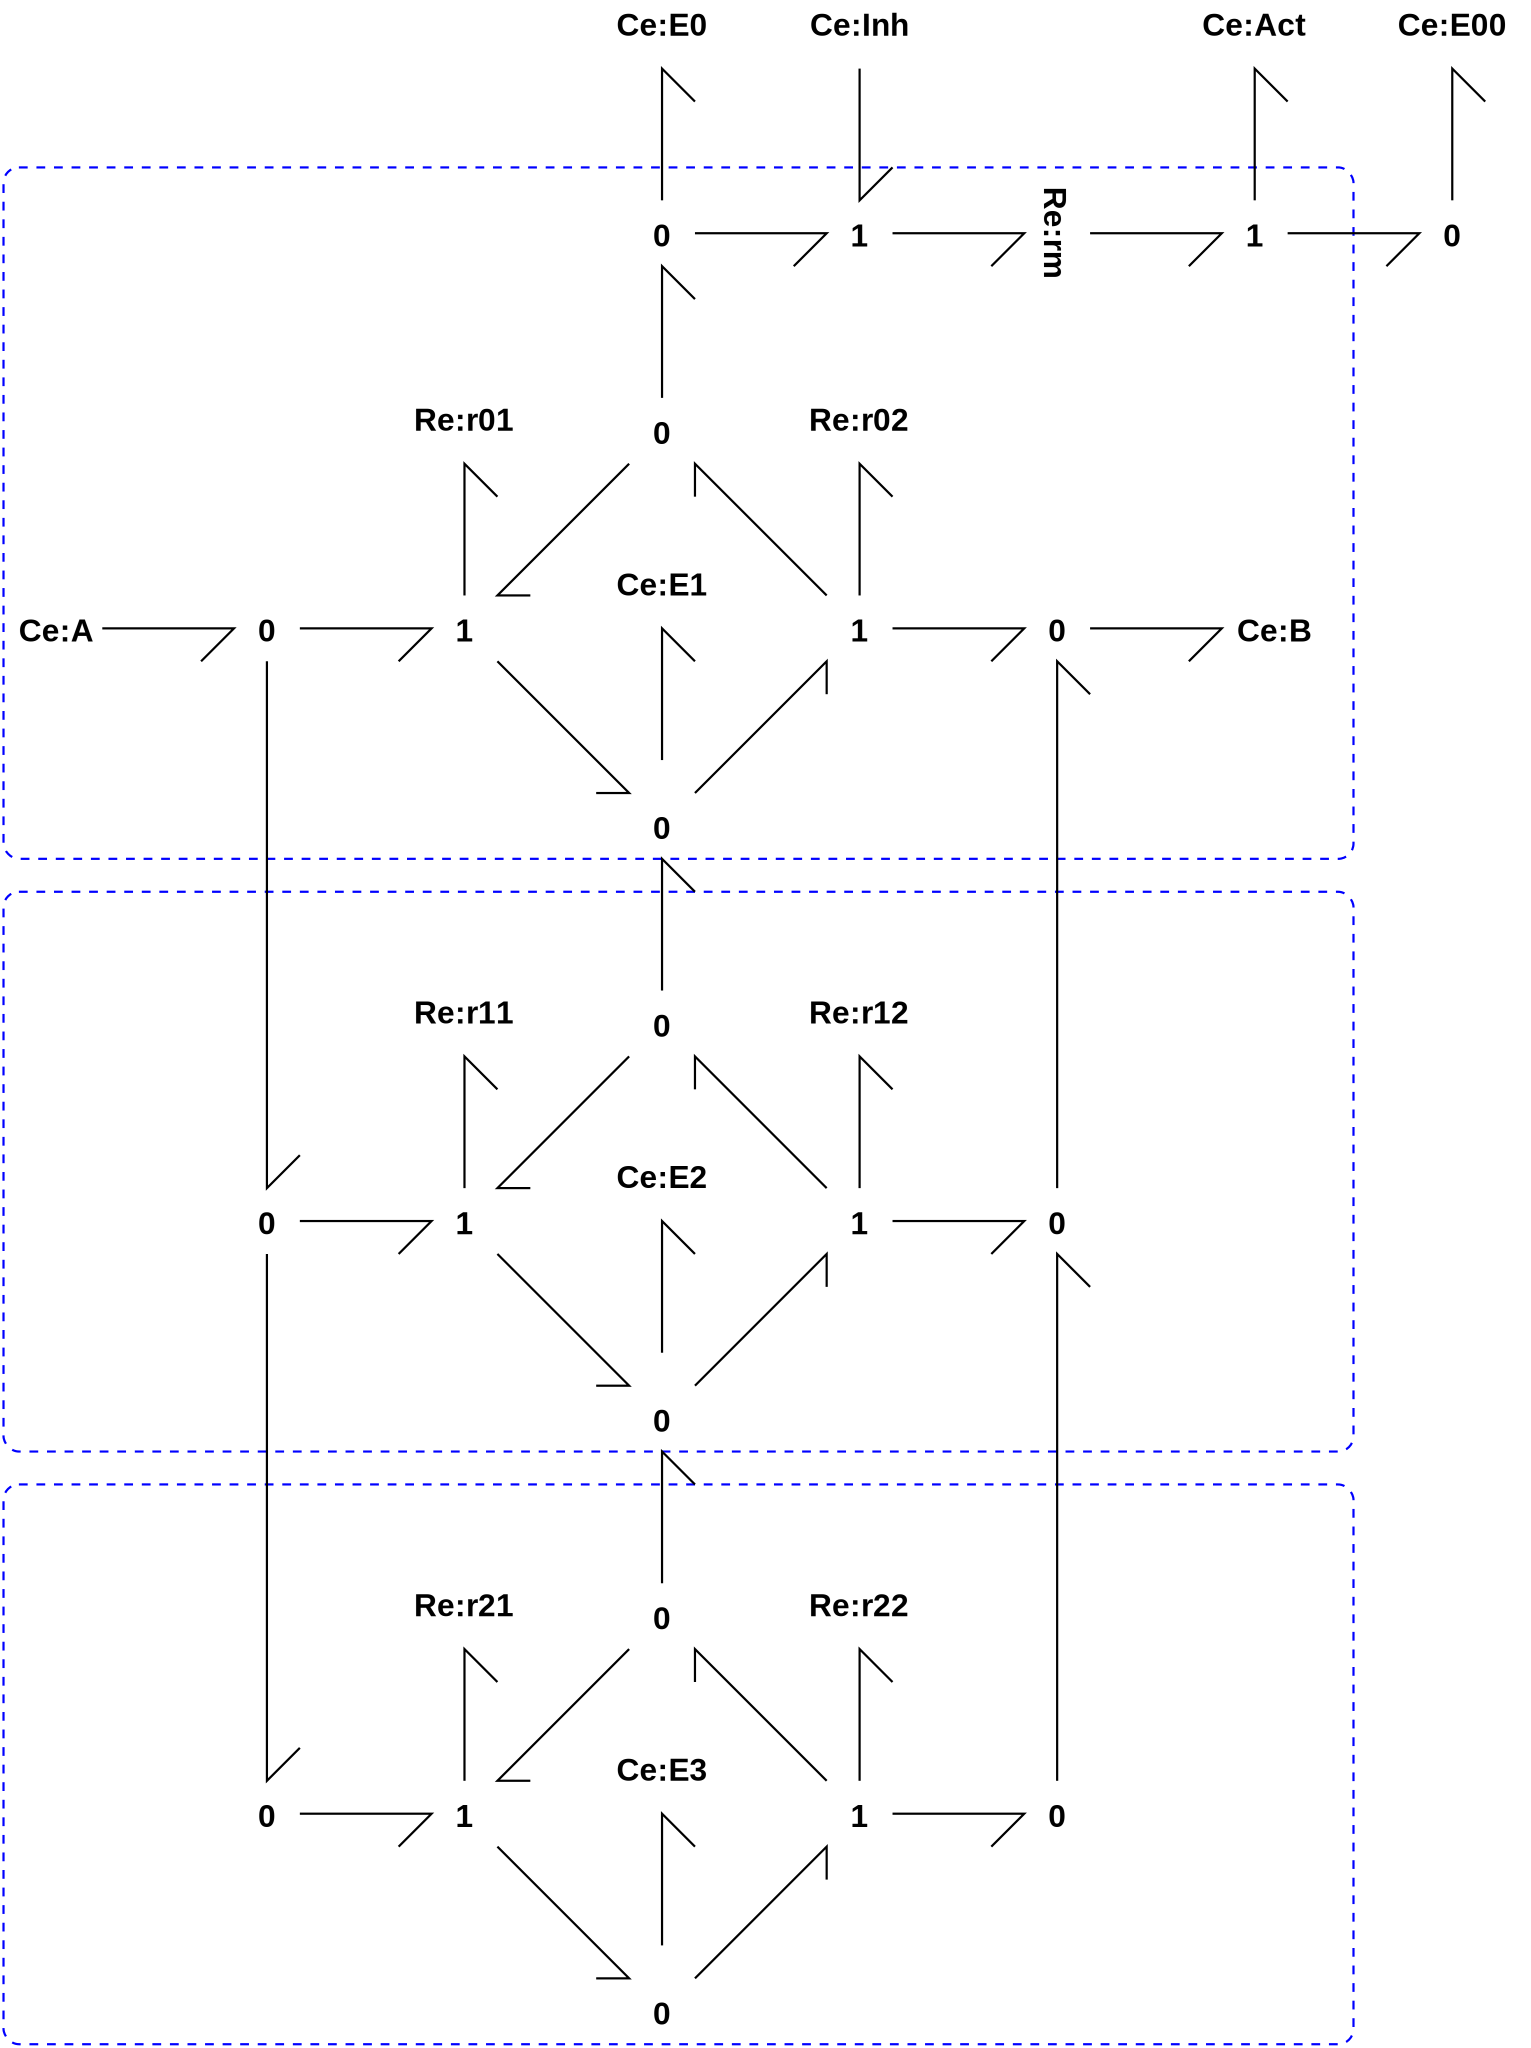

In [6]:
## Two-stage cooperative enzyme-catalysed reaction (N=2)
sbg.model('mCoop_abg.svg',quiet=quiet)
import mCoop_abg
disp.SVG('mCoop_abg.svg')

In [7]:
s = st.stoich(mCoop_abg.model(),quiet=quiet)
sc = st.statify(s,chemostats=['A','B','Act','Inh'])
disp.Latex(st.sprintrl(s,chemformula=True))


<IPython.core.display.Latex object>

## Create cooperative enzyme-catalysed reaction of any degree N
The following code builds an N-stage cooperative enzyme-catalysed reaction using  [bond-graph tools](https://pypi.org/project/BondGraphTools/).

1. N+1 instances of the basic enzyme-catalysed reaction are created and the enzyme and complex renamed.
2. The substrate A, product B  and enzymes E1-EN are unified.

In [8]:
## Create cooperative enzyme-catalysed reaction of any degree N
## Optionally append a simple reaction
## Optionally use feedback inhibition
def makeCoop(N=3,quiet=True):
    Coop = bgt.new(name='Coop')
    Mod = Mod_abg.model()
    Coop.add(Mod)
    for i in range(N+1):
        RE = RE_abg.model()
        RE.name = 'RE'+str(i)
        mbg.rename(RE,{
                    'E':'E'+str(i), 
                    'C':'E'+str(i+1),
                    'r1':'r'+str(i)+'1',
                    'r2':'r'+str(i)+'2'
                    },
                   quiet=quiet)
        Coop.add(RE)

    ## Unify common components
    unified = ['A','B','E0']
    for i in range(N): 
        Ei = 'E'+str(i+1)
        unified.append(Ei)
    #print('unified =',unified)
    mbg.unify(Coop,unified,quiet=quiet)

        
    ## Stoichiometry
    chemostats = ['A','B','Act','Inh']
    s = st.stoich(Coop,quiet=quiet)
    sc = st.statify(s,chemostats=chemostats)
    if not quiet:
        print(st.sprint(sc,'species'))
        print(st.sprint(sc,'reaction'))
    return s,sc,Coop

### Generate equations for $N=2$
Note that these equations are identical to those of the explicit bondgraph.

In [9]:
### Generate equations for N=2
s,sc,Coop = makeCoop(N=2,quiet=quiet)
disp.Latex(st.sprintrl(s,chemformula=True))

<IPython.core.display.Latex object>

### Generate pathway equations for $N=2$
Pathways are generated using the approach of <cite data-cite="GawCra17">Gawthrop and Crampin (2014)</cite>.

In [10]:
sp = st.path(s,sc)
print(st.sprintp(sc))
disp.Latex(st.sprintrl(sp))

3 pathways
0:  + r01 + r02
1:  + r11 + r12
2:  + r21 + r22



<IPython.core.display.Latex object>

# Simulation of Steady-state properties

The steady state properties are investigated using dynamic simulation where slowly varing exogenous quantities are used to induce quasi-steady-state behaviour. In each case, the variable is at a constant value to start with followed by a slowly increasing ramp. The response after the initial reponse is plotted to remove artefacts due to the initial transient.

All parameters are unity except for $K_B=10^{-6}$ (to approximate an irreversible reaction) and initial states are chosen so that the total enzyme is $e_0=1$.

## Set up some parameters for simulation

In [11]:
## Set up some parameters for simulation
def setParameter(s,N,e0,K_B=1e-6,modulate=True):
    ## Set up the non-unit parameters and states
    
    K_E0 = 1
    K_EN = 1/K_E0
    K_m = K_EN/K_E0
    parameter = {}

    ## Set product constant to a small value
    ## to make the ECR approximately irreversible
    parameter['K_B'] = K_B
    
    ## Set up enzyme parameters and reaction constants
    parameter['K_E0'] = K_E0
    parameter['K_E'+str(N+1)] = K_EN
    
    ## Modulation 
    parameter['kappa_rm'] = 1e3
    parameter['K_E00'] = 1e-1
    
    ## States
    ## Set total enzyme to e0
    X0 = np.ones(s['n_X'])
    if modulate:
        X0[s['spec_index']['Act']] = 100
        X0[s['spec_index']['E00']] = (e0/(N+3))
        for i in range(N+2):
            Ei = 'E'+str(i)
            X0[s['spec_index'][Ei]] = (e0/(N+3))
    else:
          for i in range(N+2):
            Ei = 'E'+str(i)
            X0[s['spec_index'][Ei]] = (e0/(N+2))
          

          
    return parameter,X0,K_EN,K_m

## Simulation code
The flow $v$ is a dynamical function of substrate $x_A$, activation $x_{Act}$, inhibition $x_{Inh}$ and cooperativity index $N$. An approximate steady-state is acjieved by varying one of the three concentrations slowly whilst fixing the other two. The following function does this by declaring the varying function species by the string sX, a fixed species with a number of discrete values as sX1 with values XX1 and the other species as sX2 with value X2.
N can take on a range of values.

deriv=True gives a plot of the derivative of the flow with respect to $\log_{10} X$.

In [12]:
def label(sX1,sX2,X1,X2,N):
    if N<0:
        return f'{sX1}={X1}, N={-N} (graphical)'
    else:
        return f'{sX1}={X1}, N={N}'

def VaryX(sX='A',sX1='Act',sX2='Inh',XX1=[0.1,1,10],X2=1,NN=[2],K_B=1e-6,deriv=False):

    ## Time
    t_max = int(1e4)
    t = np.linspace(0,t_max,100000)
    t_0 = 100
    t_1 = t_max-t_0
    i_max = len(t)
    i_0 = int(i_max*t_0/t_max)
    i_1 = i_max-i_0

    
    ## Set up the chemostats: vary X
    x_max = 1e2
    x_min = 1e-2
    chemo = '{3} + ({0}-{3})*np.heaviside(t-{1},1)*((t-{1})/{2})'.format(x_max,t_0,t_1,x_min)
    X_chemo =  {sX:chemo}
    
    for N in NN:
        for X1 in XX1:
            
            if N<0:
                ## Use graphical version
                s = st.stoich(mCoop_abg.model(),quiet=quiet)
                sc = st.statify(s,chemostats=['A','B','Act','Inh'])
                lw = 6
                ls = 'dashed'
            else:
                ## Use computational version    
                s,sc,Coop = makeCoop(N=N,quiet=quiet)
                lw = 4
                ls = None

            ## Non-unit parameters and states
            e0 = 1 # Total enzyme
            parameter,X0,K_EN,K_m = setParameter(s,abs(N),e0,K_B=K_B)
            X0[s['spec_index'][sX1]] = X1
            X0[s['spec_index'][sX2]] = X2
            dat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=X0,X_chemo=X_chemo,quiet=quiet)
            dX  = s['N']@(dat['V'].T)
            dX_B = dX[s['spec_index']['B'],:]
            V = dX_B
            X = dat['X'][:,s['spec_index'][sX]]
            
            if deriv:
                slope = np.gradient(V[-i_1:],np.log10(X[-i_1:]))
                plt.semilogx(X[-i_1:],slope,lw=lw,label=label(sX1,sX2,X1,X2,N),linestyle=ls)
                ylabel = '$dv/d \log_{10}{x}$'
                             
            else:
                plt.semilogx(X[-i_1:],V[-i_1:],lw=lw,label=label(sX1,sX2,X1,X2,N),linestyle=ls)
                ylabel = '$v$'
 

    
    plt.xlabel('$x_{'+sX+'}$')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    #plt.title('N = '+str(N))
    plt.show()
  

## Vary the substrate concentration.

 The substrate concentration $x_A$ is varied for two values of activation $x_{Act}$ and two values of $N$.
 The derivative is also plotted.

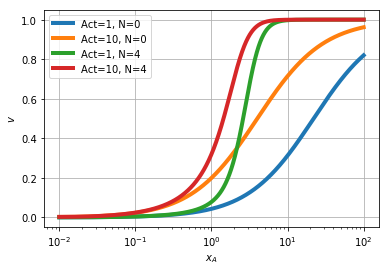

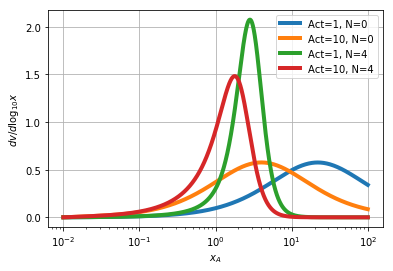

In [13]:
NN = [0,4]
VaryX(sX='A',sX1='Act',sX2='Inh',XX1=[1,10],X2=1,NN=NN)
VaryX(sX='A',sX1='Act',sX2='Inh',XX1=[1,10],X2=1,NN=NN,deriv=True)

## Vary the activation species concentration.

 The activation species concentration $x_{Act}$ is varied for two values of $N$. The derivative is also plotted.

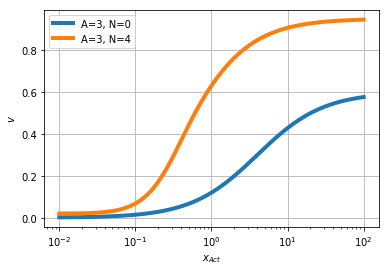

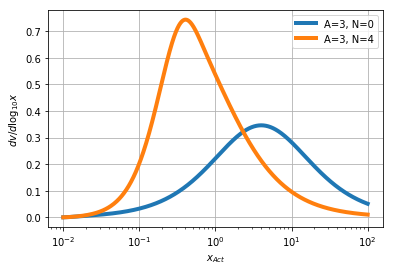

In [14]:
VaryX(sX='Act',sX1='A',sX2='Inh',XX1=[3],X2=1,NN=NN,deriv=False)
VaryX(sX='Act',sX1='A',sX2='Inh',XX1=[3],X2=1,NN=NN,deriv=True)

## Vary the substrate concentration.

 The substrate concentration $x_A$ is varied for two values of inhibition $x_{Inh}$ and two values of $N$.
 The derivative is also plotted.

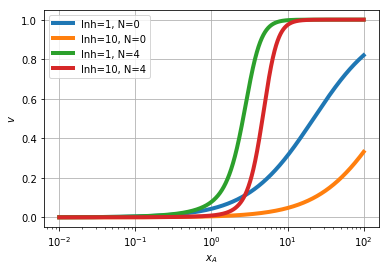

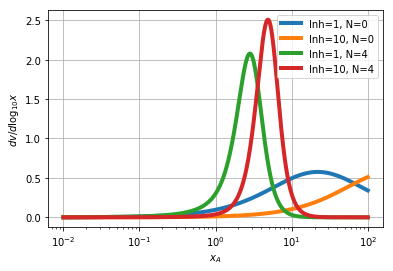

In [15]:
VaryX(sX='A',sX1='Inh',sX2='Act',XX1=[1,10],X2=1,NN=NN)
VaryX(sX='A',sX1='Inh',sX2='Act',XX1=[1,10],X2=1,NN=NN,deriv=True)

## Vary the inhibition species concentration.

 The inhibition species concentration $x_{Inh}$ is varied for two values of $N$. The derivative is also plotted.

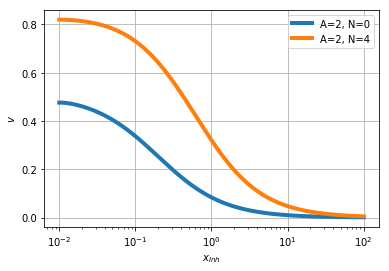

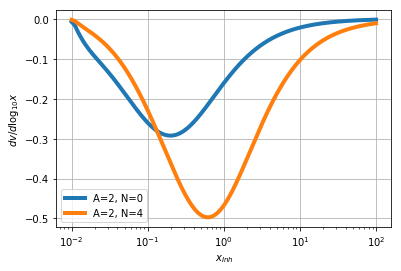

In [16]:
VaryX(sX='Inh',sX1='A',sX2='Act',XX1=[2],X2=1,NN=NN)
VaryX(sX='Inh',sX1='A',sX2='Act',XX1=[2],X2=1,NN=NN,deriv=True)

## Effect of product 
The above simulations have $K_B = 10^{-6}$; the following shows the effect of increasing $K_B$.

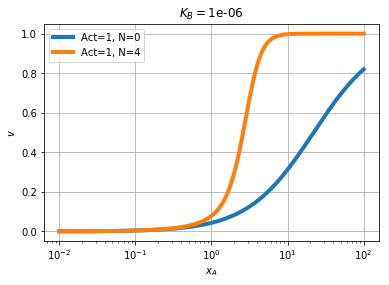

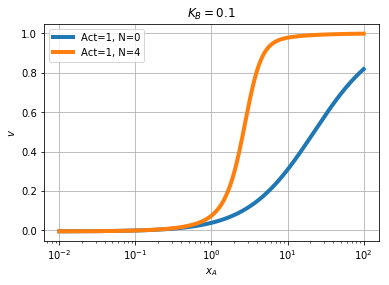

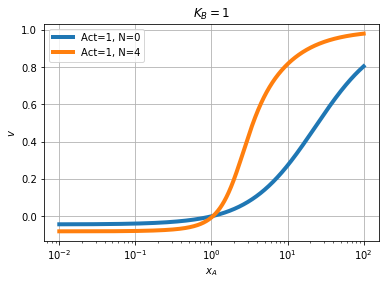

In [17]:
for K_B in [1e-6,0.1,1]:
    plt.title('$K_B = $'+str(K_B))
    VaryX(sX='A',sX1='Act',sX2='Inh',XX1=[1],X2=1,NN=NN,K_B=K_B)


## Compare graphical and computational
The graphical bond-graph representation corresponds to N=2 (activated in the code by setting N=-2). This section checks that the simulation gives the same results for the coresponding computational form of the bond graph (N=2).

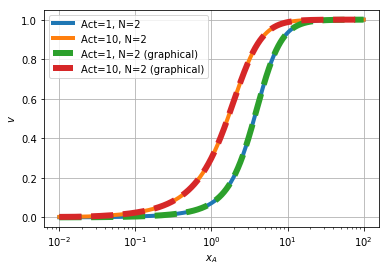

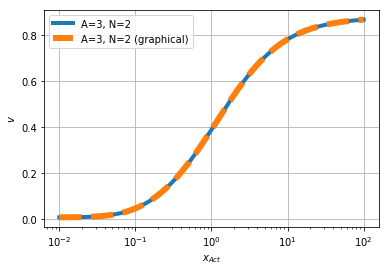

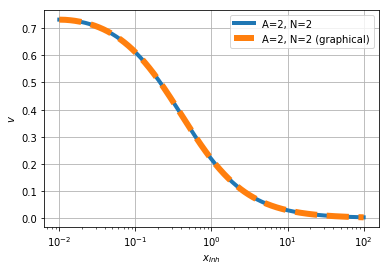

In [18]:
NN = [2,-2]
VaryX(sX='A',sX1='Act',sX2='Inh',XX1=[1,10],X2=1,NN=NN)
VaryX(sX='Act',sX1='A',sX2='Inh',XX1=[3],X2=1,NN=NN)
VaryX(sX='Inh',sX1='A',sX2='Act',XX1=[2],X2=1,NN=NN)

# Discussion

- The maximum flowrate is unchanged by activation or inhibition.

- Increasing the cooperativity order $N$ increases the slope of the curves and the incremental gain with respect to   substrate, activation and inhibition.

- It is necessary that the product potential is small. It is a chemostat here and this is acjeived by a small $K_B$. In a real situation, this could be acheived by removing product rapidly, having a product with small standard potential or using energy pumping via, for example ATP hydrolysis.

- the behaviour is dependent on the parameters of the particular enzyme-catalysed reaction; those used here are for illustration.